### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

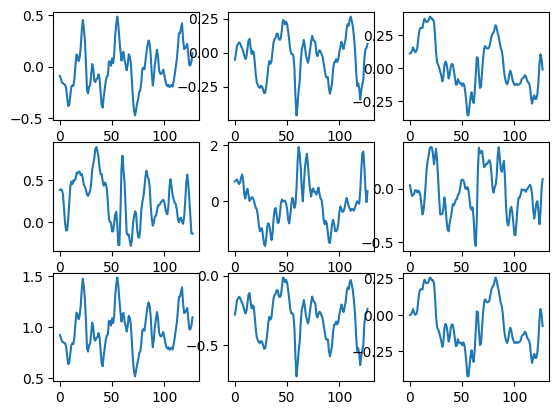

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [9]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df, cm

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, InputLayer

def build_model_single_layer_RNN(input_shape, num_classes):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(SimpleRNN(units=64))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_multi_layers_RNN(input_shape, num_classes):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(SimpleRNN(units=64, return_sequences=True))
    model.add(SimpleRNN(units=32))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_CNN(input_shape, num_classes):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Conv1D(filters=16, kernel_size=5, strides=2, activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_model_mixed_CNN_RNN(input_shape, num_classes):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Conv1D(filters=16, kernel_size=5, strides=2, activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example of how to call each function:
input_shape = (128, 9)
num_classes = 6

model_single_rnn = build_model_single_layer_RNN(input_shape, num_classes)
model_multi_rnn = build_model_multi_layers_RNN(input_shape, num_classes)
model_cnn = build_model_CNN(input_shape, num_classes)
model_mixed = build_model_mixed_CNN_RNN(input_shape, num_classes)

    

2024-05-11 09:49:46.503581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 09:49:47.133463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-11 09:49:47.556303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 09:49:47.578782: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Fo

### Single Layer SimpleRNN

In [11]:
### START YOUR CODE
input_shape = (128, 9)
num_classes = 6
model1 = build_model_single_layer_RNN(input_shape, num_classes)
### END YOUR CODE

model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,126 (20.02 KB)

 Trainable params: 5,126 (20.02 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
### START YOUR CODE
batch_size = 64
n_epochs   = 30

log1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3984 - loss: 1.4338 - val_accuracy: 0.5860 - val_loss: 0.9450
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6267 - loss: 0.8121 - val_accuracy: 0.6179 - val_loss: 0.7762
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6623 - loss: 0.7506 - val_accuracy: 0.6003 - val_loss: 0.9583
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5859 - loss: 1.1277 - val_accuracy: 0.6094 - val_loss: 0.7865
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6972 - loss: 0.6568 - val_accuracy: 0.6756 - val_loss: 0.6848
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7053 - loss: 0.6813 - val_accuracy: 0.6607 - val_loss: 0.7407
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7099 - loss: 0.6302 - val_accuracy: 0.6590 - val_loss: 0.7701
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6912 - loss: 0.7978 - val_accuracy

Train accuracy (end): 0.8782644271850586
Train accuracy (max): 0.8877856135368347
Test accuracy (end) : 0.7774007320404053
Test accuracy (max) : 0.838819146156311


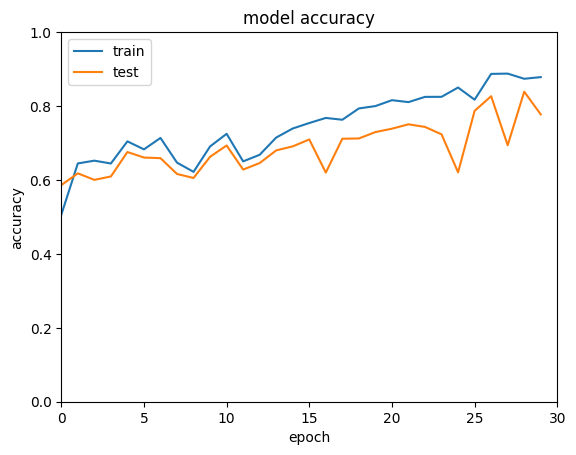

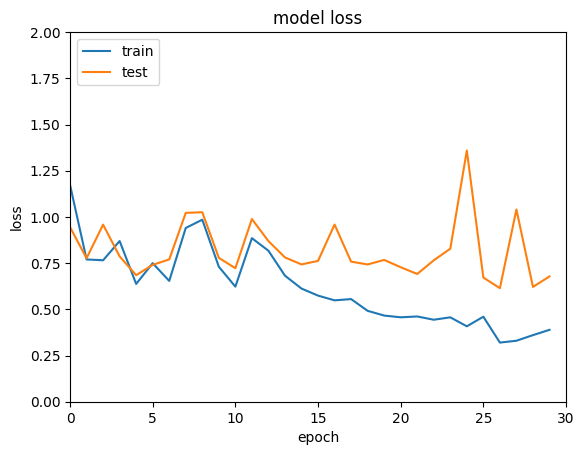

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(       walk   up  down  sit  stand  lay
 walk    389   55    35   15      2    0
 up      120  321    24    2      4    0
 down    129   18   267    5      0    1
 sit       2   17     0  397     72    3
 stand     4    5     0  111    412    0
 lay       8   19     3    2      0  505,
 array([[389,  55,  35,  15,   2,   0],
        [120, 321,  24,   2,   4,   0],
        [129,  18, 267,   5,   0,   1],
        [  2,  17,   0, 397,  72,   3],
        [  4,   5,   0, 111, 412,   0],
        [  8,  19,   3,   2,   0, 505]]))

In [13]:
performance_plots(model1, X_test, Y_test, log1, n_epochs)
confusion_matrix(model1, X_test, Y_test)

#### Findings

cf end analysis

### Stacked Simple RNNs

In [14]:
### START YOUR CODE

model2 = build_model_multi_layers_RNN(input_shape, num_classes)

### END YOUR CODE

model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 128, 64)        │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,038 (31.40 KB)

 Trainable params: 8,038 (31.40 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
### START YOUR CODE
batch_size = 64
n_epochs   = 30

log2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4998 - loss: 1.2588 - val_accuracy: 0.6105 - val_loss: 0.9512
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6834 - loss: 0.7283 - val_accuracy: 0.6603 - val_loss: 0.7656
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7333 - loss: 0.6367 - val_accuracy: 0.7268 - val_loss: 0.6600
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7931 - loss: 0.5155 - val_accuracy: 0.7177 - val_loss: 0.7352
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7905 - loss: 0.5441 - val_accuracy: 0.7791 - val_loss: 0.6250
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8422 - loss: 0.4086 - val_accuracy: 0.7838 - val_loss: 0.6613
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8372 - loss: 0.4534 - val_accuracy: 0.6047 - val_loss: 1.0442
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6552 - loss: 0.8646 - val_accu

Train accuracy (end): 0.6564199924468994
Train accuracy (max): 0.854733407497406
Test accuracy (end) : 0.6291143298149109
Test accuracy (max) : 0.8137088418006897


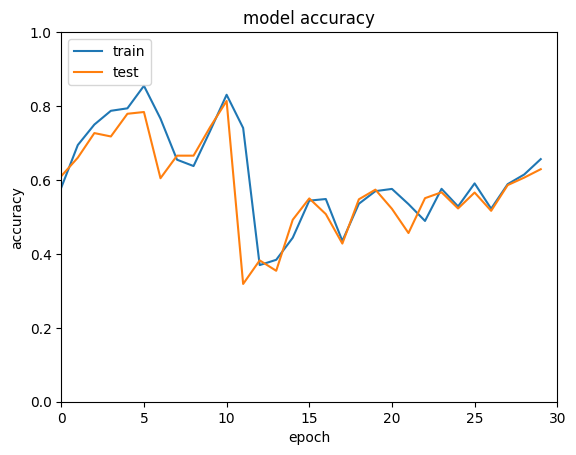

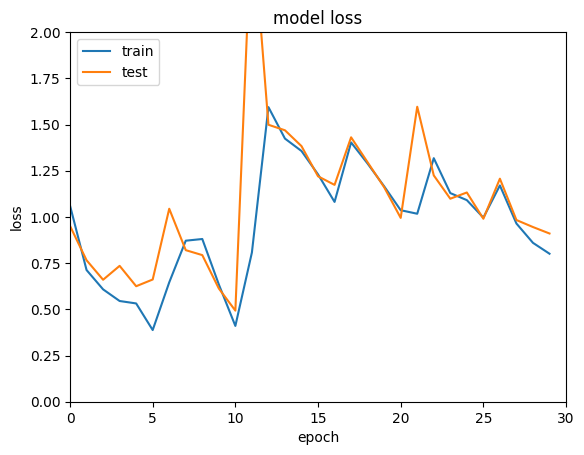

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


(       walk  up  down  sit  stand  lay
 walk    373  54    42    3     24    0
 up      308  86    52    6     15    4
 down    232  58   106    1     23    0
 sit       1   1     0  365    124    0
 stand     3   0     0   97    432    0
 lay      22  21     1    1      0  492,
 array([[373,  54,  42,   3,  24,   0],
        [308,  86,  52,   6,  15,   4],
        [232,  58, 106,   1,  23,   0],
        [  1,   1,   0, 365, 124,   0],
        [  3,   0,   0,  97, 432,   0],
        [ 22,  21,   1,   1,   0, 492]]))

In [16]:
performance_plots(model2, X_test, Y_test, log2, n_epochs)
confusion_matrix(model2, X_test, Y_test)

#### Findings

cf end analysis

### Several CNN Layers

In [17]:
### START YOUR CODE

model3 = build_model_CNN(input_shape, num_classes)
### END YOUR CODE

model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 62, 16)         │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 60, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 58, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 56, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │        21,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,374 (165.52 KB)

 Trainable params: 42,374 (165.52 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
### START YOUR CODE
batch_size = 64
n_epochs   = 30

log3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6008 - loss: 0.9683 - val_accuracy: 0.8219 - val_loss: 0.5535
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9091 - loss: 0.2491 - val_accuracy: 0.8884 - val_loss: 0.3660
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9460 - loss: 0.1355 - val_accuracy: 0.8649 - val_loss: 0.5239
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9457 - loss: 0.1278 - val_accuracy: 0.8707 - val_loss: 0.5962
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9456 - loss: 0.1186 - val_accuracy: 0.9101 - val_loss: 0.5249
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9550 - loss: 0.1063 - val_accuracy: 0.8955 - val_loss: 0.6373
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9570 - loss: 0.1038 - val_accuracy: 0.9121 - val_loss: 0.5569
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9564 - loss: 0.1000 - val_accuracy: 0.

Train accuracy (end): 0.9721164107322693
Train accuracy (max): 0.9721164107322693
Test accuracy (end) : 0.9182218909263611
Test accuracy (max) : 0.9348490238189697


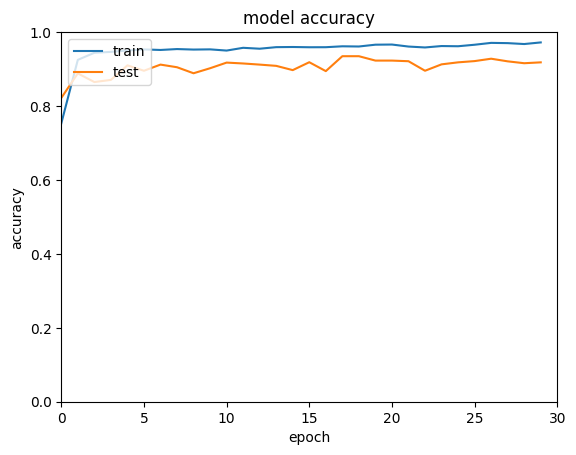

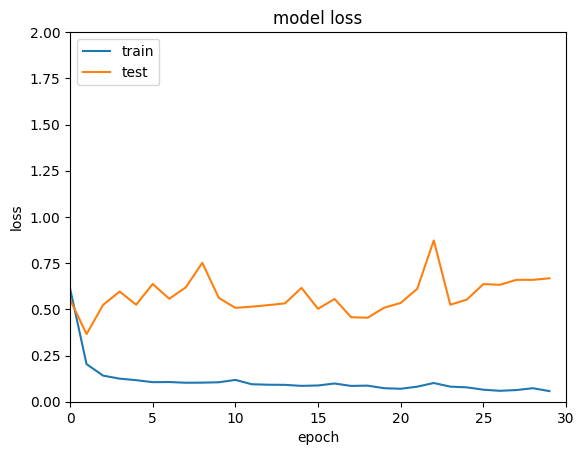

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(       walk   up  down  sit  stand  lay
 walk    483   11     2    0      0    0
 up        1  459    11    0      0    0
 down      1    6   413    0      0    0
 sit       2   20     0  396     69    4
 stand     3   35     0   76    418    0
 lay       0    0     0    0      0  537,
 array([[483,  11,   2,   0,   0,   0],
        [  1, 459,  11,   0,   0,   0],
        [  1,   6, 413,   0,   0,   0],
        [  2,  20,   0, 396,  69,   4],
        [  3,  35,   0,  76, 418,   0],
        [  0,   0,   0,   0,   0, 537]]))

In [19]:
performance_plots(model3, X_test, Y_test, log3, n_epochs)
confusion_matrix(model3, X_test, Y_test)

#### Findings

cf end analysis

### Mixed CNN and RNN

In [20]:
### START YOUR CODE

model4 = build_model_mixed_CNN_RNN(input_shape, num_classes)

### END YOUR CODE

model4.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 62, 16)         │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 60, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 58, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 56, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       229,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,694 (979.27 KB)

 Trainable params: 250,694 (979.27 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
### START YOUR CODE
batch_size = 64
n_epochs   = 30

log4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6533 - loss: 0.9036 - val_accuracy: 0.8052 - val_loss: 0.5646
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9012 - loss: 0.2519 - val_accuracy: 0.8707 - val_loss: 0.3983
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9439 - loss: 0.1427 - val_accuracy: 0.8958 - val_loss: 0.3823
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.1067 - val_accuracy: 0.8829 - val_loss: 0.3574
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9473 - loss: 0.1168 - val_accuracy: 0.9036 - val_loss: 0.2928
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9532 - loss: 0.1083 - val_accuracy: 0.8958 - val_loss: 0.3335
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9581 - loss: 0.0959 - val_accuracy: 0.8975 - val_loss: 0.3402
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9514 - loss: 0.1049 - val_accuracy: 0.

Train accuracy (end): 0.9710282683372498
Train accuracy (max): 0.972660481929779
Test accuracy (end) : 0.8968442678451538
Test accuracy (max) : 0.9209365248680115


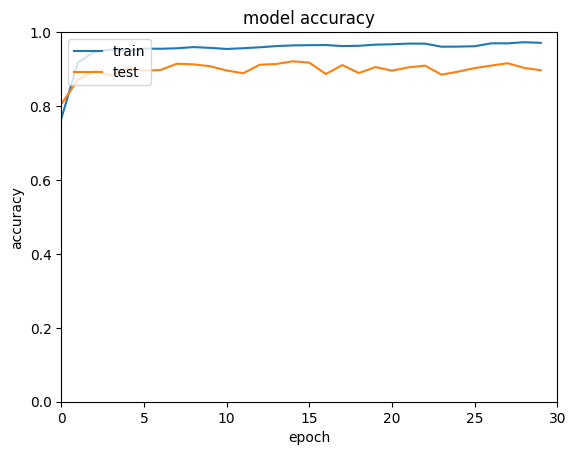

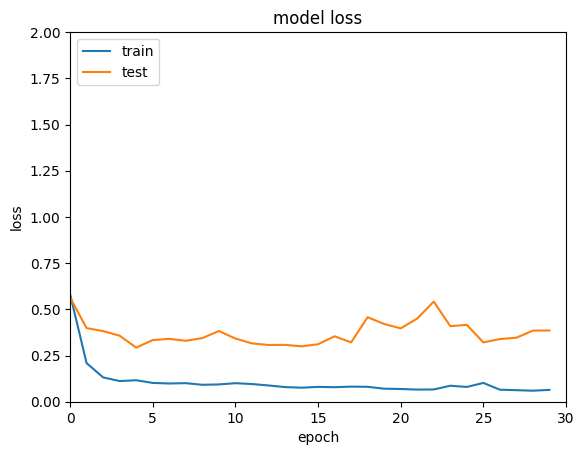

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(       walk   up  down  sit  stand  lay
 walk    483    0    11    0      2    0
 up        7  423    41    0      0    0
 down      5    4   411    0      0    0
 sit       1    6     0  349    116   19
 stand     1    2     0   89    440    0
 lay       0    0     0    0      0  537,
 array([[483,   0,  11,   0,   2,   0],
        [  7, 423,  41,   0,   0,   0],
        [  5,   4, 411,   0,   0,   0],
        [  1,   6,   0, 349, 116,  19],
        [  1,   2,   0,  89, 440,   0],
        [  0,   0,   0,   0,   0, 537]]))

In [22]:
performance_plots(model4, X_test, Y_test, log4, n_epochs)
confusion_matrix(model4, X_test, Y_test)

#### Findings

cf end analysis

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


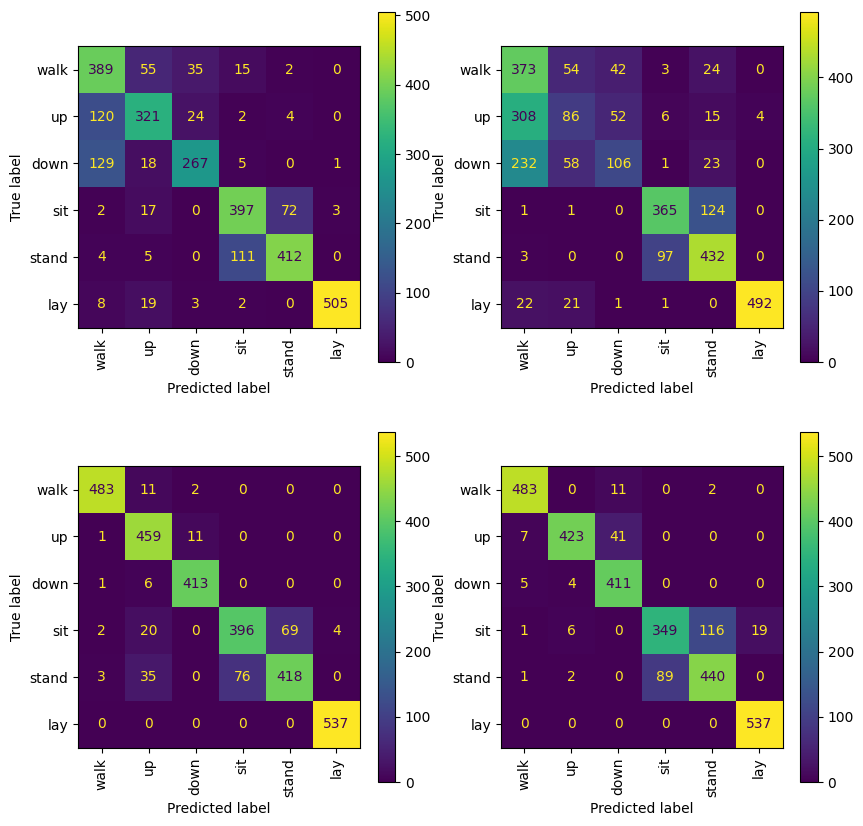

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

df1, cm1 = confusion_matrix(model1, X_test, Y_test)
df2, cm2 = confusion_matrix(model2, X_test, Y_test)
df3, cm3 = confusion_matrix(model3, X_test, Y_test)
df4, cm4 = confusion_matrix(model4, X_test, Y_test)

fig, axs = plt.subplots(2, 2, figsize=(10,10))
disp1 = ConfusionMatrixDisplay(cm1, display_labels=activities)
disp1.plot(ax=axs[0,0], xticks_rotation='vertical')
disp2 = ConfusionMatrixDisplay(cm2, display_labels=activities)
disp2.plot(ax=axs[0,1], xticks_rotation='vertical')
disp3 = ConfusionMatrixDisplay(cm3, display_labels=activities)
disp3.plot(ax=axs[1,0], xticks_rotation='vertical')
disp4 = ConfusionMatrixDisplay(cm4, display_labels=activities)
disp4.plot(ax=axs[1,1], xticks_rotation='vertical')
plt.show()



#### Findings

The first thing to note is that the labels `sit` and `stand` are easily mixed-up together. The same holds for the labels `walk` and `walkdown` and `walkup`. The simple RNN model has a hard time distinguishing these activities. The CNN model does a better job at this. The mixed model does a good job at distinguishing all activities.